### Fetch MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
print("X:", X.shape)
print("y:", y.shape)

X: (70000, 784)
y: (70000,)


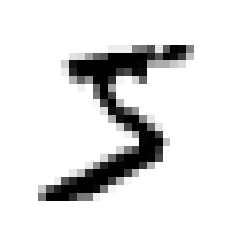

y= 5


In [5]:
# take a look at the 'data'
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()
print("y=", y[0])

In [7]:
import numpy as np

y=y.astype(np.uint8)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### train a classifier to recognize 5s

In [9]:
#true and false if the target is a 5
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [10]:
#create and train a stochastic gradient descent classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
#does it work on our 5 above?
print("Is it 5?",sgd_clf.predict([some_digit]))

Is it 5? [ True]


### measure accuracy with cross-validation

In [18]:
#custom implemenation of cross-validation (similar to scikit-learn's cross_val_score)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


In [19]:
#use cross_val_score() to evaluate the model
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [20]:
#how about we make our own classifier to make everything 'not 5'
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)


In [21]:
#this is 'accurate' because only ~ 10% of the data are 5s
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [22]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

# Confusion matrix
#                 |    Not 5 predictions         |    5 Predications         |
# Actual Not 5's  | not 5's correctly identified | not 5's classified as 5's |
# Actual 5's      | 5's classified as not 5's    | 5's correctly identified  |

array([[53892,   687],
       [ 1891,  3530]])

In [23]:
# precision = True Positive/(True Positive + False Positive)
# recall/sensitivity/true positive rate = True Positive/(True Positive + False Negative)
# Confusion matrix redux
#           |  Negative      |  Positive      |
# Negative  | True Negative  | False Positive |
# Positive  | False Negative | True Positive  |

from sklearn.metrics import precision_score, recall_score
print("Precision",precision_score(y_train_5, y_train_pred))
print("Sensitivity",recall_score(y_train_5, y_train_pred))

Precision 0.8370879772350012
Sensitivity 0.6511713705958311


In [24]:
#F1 score (or harmonic mean)
# F1 = 2/((1/precision)+(1/recall))=True Positive/(True Positive + ((False Negative + False Positive)/2))
from sklearn.metrics import f1_score
print("F1 Score:",f1_score(y_train_5, y_train_pred))

F1 Score: 0.7325171197343846


In [26]:
#look at the sgd decision score
y_scores = sgd_clf.decision_function([some_digit])
print("Decision score:", y_scores)

#sgd compares the decision score to a threshold to classify something
#you could classify it manually like this:
threshold = 100
print("Over threshold?", (y_scores > threshold))

Decision score: [2164.22030239]
Over threshold? [ True]
